<h1>Salary Predictions Based on Job Descriptions</h1>

# Part 1 - DEFINE

### ---- 1 The problem ----

The job market is complex. HR must have a clear understanding of what an appropriate salary is for a new job posting and how various factors can affect the salary offered.

The goal of this project is to examine a set of existing job postings with salaries and use this data to predict the salaries for a new set of job postings.

Factors include:
- highest level of degree earned
- year of experience
- job title
- the industry the job is in
- how far from the nearest metropolis


__author__ = "Jennifer Ma"
__email__ =

## Part 2 - DISCOVER



In [2]:
#import libraries used for data manipulation and visual representation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk

<h3>2. Load the data</h3>

The data provided separates the salary information and the factors that may be influencing the offered salary in another.

In [3]:
#load the data into a Pandas dataframe
salary_df = pd.read_csv('data/train_salaries.csv')
salary_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [4]:
train_features_df = pd.read_csv('data/train_features.csv')
train_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [9]:
# Merge the two training set dataframes together.

training_df = pd.merge(salary_df, train_features_df, how='left', on='jobId')
training_df.head()

,jobId,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


<h3>3. Quality check of data</h3>

Before using the data, its important to clean the data and look for invalid data (e.g. salaries <= 0), corrupt, or duplicate data and remove it.

In [11]:
# Verify the size of the df.
training_df.shape

(1000000, 9)

In [20]:
# Check to see if there are any missing values
training_df.isnull().values.any()

True

In [22]:
# Since there are some "NaN" values, convert those to 0
training_df.replace("NaN", 0, inplace=True)

In [14]:
# Check that the data types
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
salary                 1000000 non-null int64
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 116.3+ MB


In [15]:
# Display the statistical overview of the salary
training_df.describe()

,salary,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000,1000000.000000
mean,116.061818,11.992386,49.529260
std,38.717936,7.212391,28.877733
min,0.000000,0.000000,0.000000
25%,88.000000,6.000000,25.000000
50%,114.000000,12.000000,50.000000
75%,141.000000,18.000000,75.000000
max,301.000000,24.000000,99.000000


The minimum value in the salary data is 0, which is probably an error. It doesn't make sense to have a salary of 0, so remove these values.

In [17]:
training_df['salary'].replace(0, np.nan, inplace=True)
training_df.dropna()
training_df['salary'].describe()

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

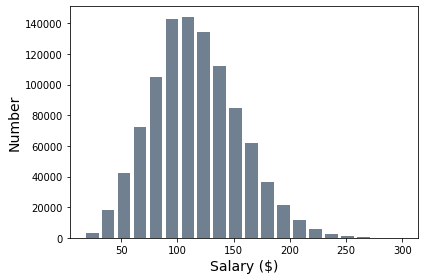

In [35]:
# Target Feature : Salary

# Graph
hist_salary = plt.hist(training_df['salary'], color= 'slategrey', rwidth = 0.8, bins= 20)
plt.xlabel("Salary ($)", size= 14)
plt.ylabel("Number", size= 14)
plt.tight_layout()
plt.show()

The salary data appears to have one peak and be symmetrically distributed.

<h2>Correlation Matrix</h2>

,salary,yearsExperience,milesFromMetropolis
salary,1.000000,0.360799,-0.295369
yearsExperience,0.360799,1.000000,0.001343
milesFromMetropolis,-0.295369,0.001343,1.000000


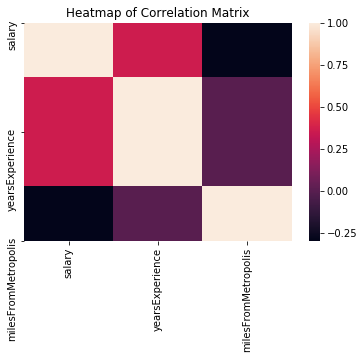

In [38]:
# Create a correlation matrix.sn
# What features correlate most with salary? Are there any other correlations?

corr = training_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns.values,
        yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

From the heatmap, it looks like years of experience correlates positively with salary while the distance away from a metropolis correlates negatively.

### ---- 4 Explore the data (EDA) ----

In [15]:
# Summarize each feature variable
features = list(training_df.columns)
print(features)

['jobId', 'salary', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']


In [16]:
# Categorical features are excluded from the correlation matrix, so manual EDA for each of them was performed

# Feature 1 = jobType
jobType_counts = training_df['jobType'].value_counts()
print(jobType_counts)

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64


In [39]:
# Select jobType
jobType = training_df[['jobType', 'salary']]

# Sort subcategories by median and mean salary
grp_jobType = jobType.groupby(['jobType']).median()
sort_jobType = grp_jobType.sort_values(['salary'], ascending = True)
sort_jobType['Mean Salary'] = jobType.groupby(['jobType']).mean()
sort_jobType = sort_jobType.rename(columns={'salary': 'Median Salary'})
sort_jobType

,Median Salary,Mean Salary
jobType,,
JANITOR,68.0,70.813045
JUNIOR,92.0,95.333087
SENIOR,102.0,105.487775
MANAGER,112.0,115.368518
VICE_PRESIDENT,122.0,125.368630
CFO,132.0,135.458547
CTO,132.0,135.481067
CEO,142.0,145.311425


[Text(0, 0, 'JANITOR'),
 Text(0, 0, 'JUNIOR'),
 Text(0, 0, 'SENIOR'),
 Text(0, 0, 'MANAGER'),
 Text(0, 0, 'VICE_PRESIDENT'),
 Text(0, 0, 'CFO'),
 Text(0, 0, 'CTO'),
 Text(0, 0, 'CEO')]

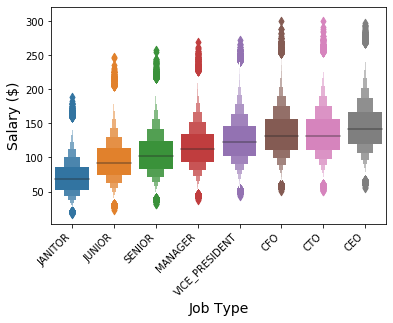

In [18]:
index_jobType = sort_jobType.index

# Graph
plot_jobType = sns.boxenplot(x='jobType', y = 'salary', data= jobType, order= index_jobType)
plt.xlabel('Job Type', size = 14)
plt.ylabel('Salary ($)', size = 14)
plot_jobType.set_xticklabels(labels = index_jobType, rotation = 45, horizontalalignment = 'right')

There is a trend that shows that having a position that is higher up within a company, the median salary also increases.

In [19]:
# Feature 2 : "degree"
degree_counts = training_df['degree'].value_counts()
degree_counts

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [40]:
# Select degree column
degree = training_df[['degree', 'salary']]

# Group degrees and determine the median salary for each degree
grp_degree = degree.groupby('degree').median()
sort_degree = grp_degree.sort_values(['salary'], ascending = True)
sort_degree['Mean Salary'] = degree.groupby('degree').mean()
sort_degree = sort_degree.rename(columns={'salary': 'Median Salary'})
sort_degree


,Median Salary,Mean Salary
degree,,
NONE,95.0,98.176882
HIGH_SCHOOL,99.0,101.921085
BACHELORS,122.0,125.454663
MASTERS,127.0,130.505647
DOCTORAL,132.0,135.490979


[Text(0, 0, 'NONE'),
 Text(0, 0, 'HIGH_SCHOOL'),
 Text(0, 0, 'BACHELORS'),
 Text(0, 0, 'MASTERS'),
 Text(0, 0, 'DOCTORAL')]

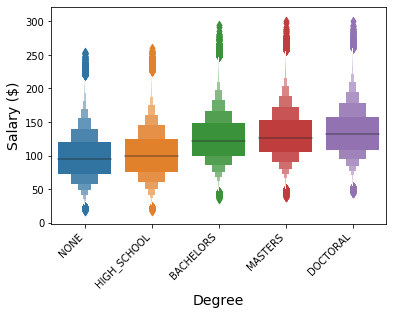

In [21]:
index_degree = sort_degree.index

# Graph
plot_degree = sns.boxenplot(x='degree', y='salary', data=degree, order=index_degree)
plt.xlabel("Degree", size = 14)
plt.ylabel("Salary ($)", size = 14)
plot_degree.set_xticklabels(labels = index_degree, rotation = 45, horizontalalignment = 'right')

Summary for degree
The more advanced of a degree a person has, there is an increase in the average salary. However, there does seem to be a distinct increase in salary between having a high school diploma versus having a college diploma.

In [22]:
# Feature 3 : major

# Major counts
major_counts = training_df['major'].value_counts()
major_counts

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [41]:
# Select major column
major = training_df[['major', 'salary']]

grp_major = major.groupby('major').median()
sort_major = grp_major.sort_values(['salary'], ascending = True)
sort_major['Mean Salary'] = major.groupby('major').mean()
sort_major = sort_major.rename(columns={'salary': 'Median Salary'})
sort_major

,Median Salary,Mean Salary
major,,
NONE,100.0,102.583864
LITERATURE,122.0,124.423097
BIOLOGY,125.0,127.932664
CHEMISTRY,126.0,129.072085
PHYSICS,127.0,130.372436
COMPSCI,129.0,132.075605
MATH,130.0,133.322042
BUSINESS,132.0,135.648980
ENGINEERING,135.0,138.441342


[Text(0, 0, 'NONE'),
 Text(0, 0, 'LITERATURE'),
 Text(0, 0, 'BIOLOGY'),
 Text(0, 0, 'CHEMISTRY'),
 Text(0, 0, 'PHYSICS'),
 Text(0, 0, 'COMPSCI'),
 Text(0, 0, 'MATH'),
 Text(0, 0, 'BUSINESS'),
 Text(0, 0, 'ENGINEERING')]

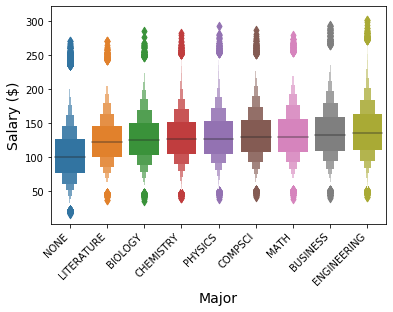

In [24]:
index_major = sort_major.index

# Graph
plot_major = sns.boxenplot(x='major', y='salary', data= major, order=index_major)
plt.xlabel("Major", size= 14)
plt.ylabel("Salary ($)", size= 14)
plot_major.set_xticklabels(labels= index_major, rotation = 45, horizontalalignment = 'right')

The data shows that the college major that was chosen does not have a large impact on the salary paid. Even those with no college major have the potential to earn over $250K per year.

In [25]:
# Feature 4 : industry

# Major counts
industry_counts = training_df['industry'].value_counts()
industry_counts

WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64

In [42]:
# Select industry column
industry = training_df[['industry', 'salary']]

grp_industry = industry.groupby('industry').median()
sort_industry = grp_industry.sort_values(['salary'], ascending = True)
sort_industry['Mean Salary'] = industry.groupby('industry').mean()
sort_industry = sort_industry.rename(columns={'salary': 'Median Salary'})
sort_industry

,Median Salary,Mean Salary
industry,,
EDUCATION,98.0,99.448386
SERVICE,103.0,104.446820
AUTO,108.0,109.435222
HEALTH,114.0,115.735540
WEB,119.0,121.645362
FINANCE,128.0,130.747659
OIL,128.0,130.953863


[Text(0, 0, 'EDUCATION'),
 Text(0, 0, 'SERVICE'),
 Text(0, 0, 'AUTO'),
 Text(0, 0, 'HEALTH'),
 Text(0, 0, 'WEB'),
 Text(0, 0, 'FINANCE'),
 Text(0, 0, 'OIL')]

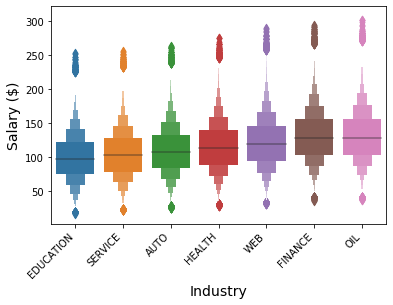

In [27]:
index_industry = sort_industry.index

# Graph
plot_industry= sns.boxenplot(x='industry', y='salary', data= industry, order=index_industry)
plt.xlabel("Industry", size= 14)
plt.ylabel("Salary ($)", size= 14)
plot_industry.set_xticklabels(labels= index_industry, rotation = 45, horizontalalignment = 'right')

EDA 2.

Correlation between different features.

There is a wide distribution of salaries that can be achieved in all industries, all degree types, job types, and majors.

Question: Considering this, is there certain industries where a higher education is a benefit in getting a higher paid job?

Question: Does having a higher education lead to having a job position that is also higher up, ultimately leading to a higher pay?

Question: How does the degree type and the number of years of experience affect the salary? After a person finishes school with a higher degree, they will generally have no industry experience, a feature that is positively correlated with salary.

In [ ]:
# What is the best way to separate out the 
grp_education = training_df.groupby('industry')


### ---- 5 Establish a baseline ----

### ---- 6 Hypothesize solution ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based

#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data